In [3]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [4]:
import torch.optim as optim

dim=2
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')


import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'simulation_gene_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '200',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.003',
    '-rm', '10',
    '--no-norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'simulation_gene_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 200, 'norm_cost': False, 'reg': 0.003, 'reg_m': 10.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [5]:
df = pd.read_csv(DATA_DIR + '/simulation_gene_data.csv')
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


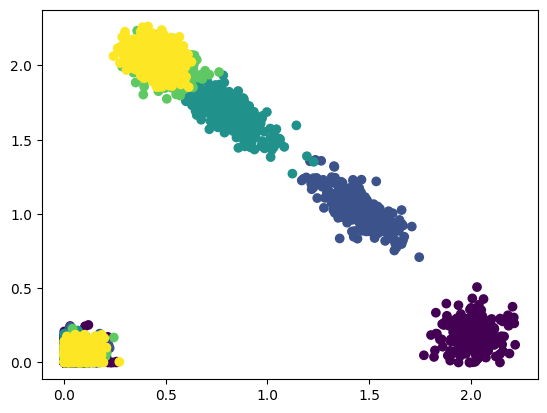

In [6]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [7]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [8]:
f_net=f_net.to(device)

In [9]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

400

In [10]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.1050, 1.3250, 1.7250, 2.4225], dtype=torch.float64)

In [11]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [12]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost
)


relative_mass tensor([1.0000, 1.1050, 1.3250, 1.7250, 2.4225], dtype=torch.float64)
t_train: [0, 1, 2, 3, 4]


Begin flow and growth matching...: 100%|██████████| 200/200 [00:03<00:00, 50.41epoch/s, loss=0.002366, vloss=0.002213, gloss=0.000152]


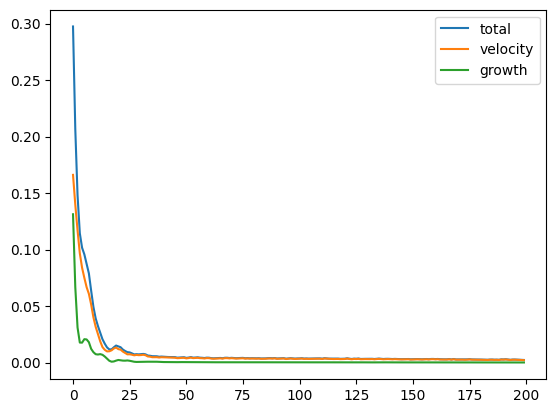

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
plt.plot(g_losses,label='growth')
plt.legend()

In [14]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [15]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

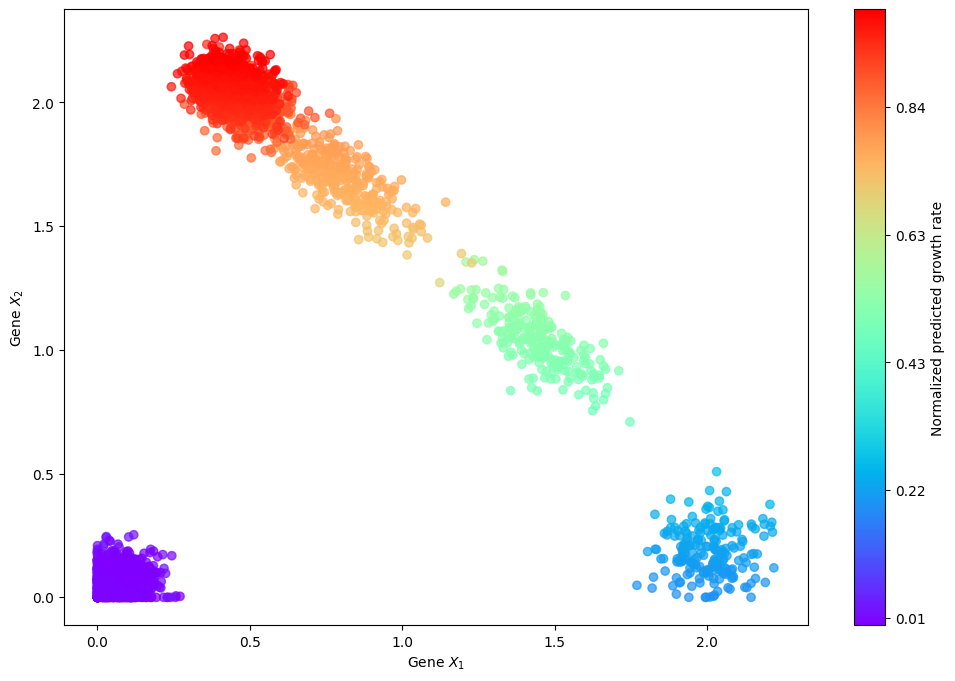

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        x = torch.tensor(subset['x1'].values, dtype=torch.float32).to(device)
        y = torch.tensor(subset['x2'].values, dtype=torch.float32).to(device)
        data = torch.stack([x, y], dim=1)
        
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g= f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 99)
    
    norm = plt.Normalize(vmin=all_g_values.min(), vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [17]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=100, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


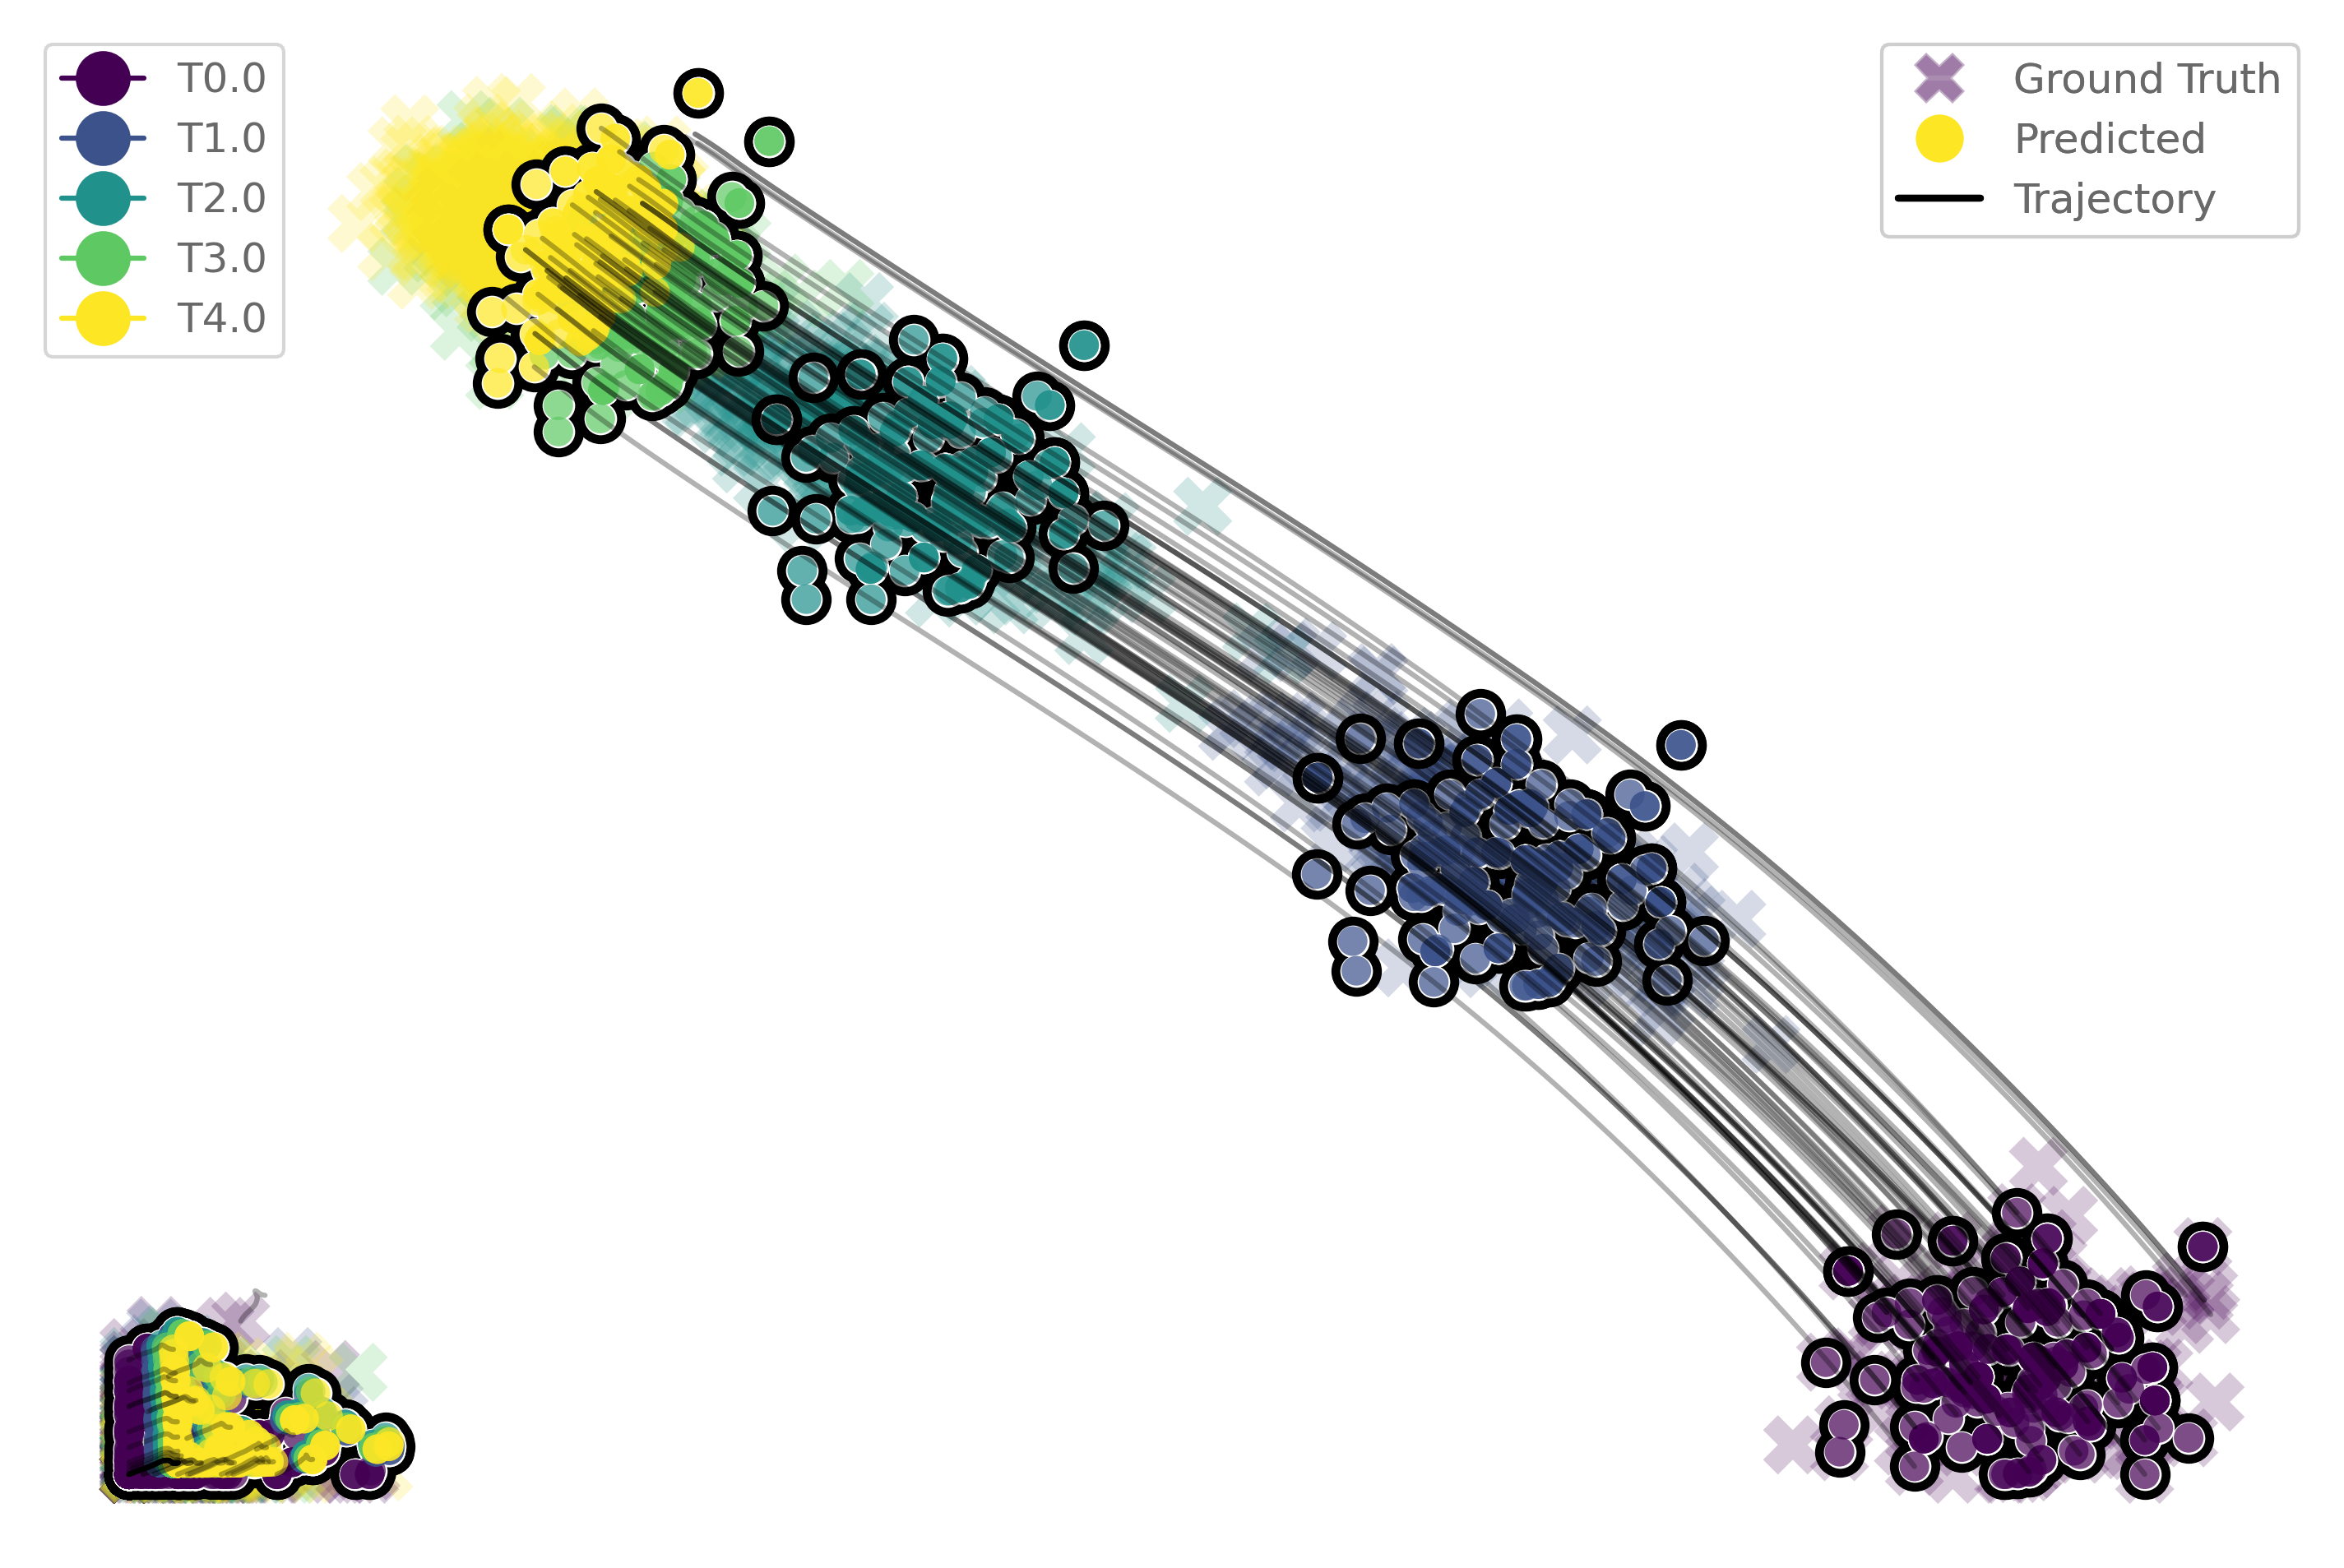

In [18]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

In [19]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.0935328006744385,relative_mass_now:1.105
RME:0.010377555950734394
Otloss:0.0555028
total loss:0.0555028
epoch_0_1:
relative_mass_pred:1.3015623092651367,relative_mass_now:1.325
RME:0.017688823196123197
Otloss:0.0677109
total loss:0.0677109
epoch_0_2:
relative_mass_pred:1.6860544681549072,relative_mass_now:1.725
RME:0.02257711991019876
Otloss:0.0536475
total loss:0.0536475
epoch_0_3:


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  3%|▎         | 1/30 [00:00<00:07,  3.72it/s]

relative_mass_pred:2.3569514751434326,relative_mass_now:2.4225
RME:0.027058214595074206
Otloss:0.0814996
total loss:0.0814996
New minimum otloss found: 0.08149956911802292. Model saved.
epoch_1_0:
relative_mass_pred:1.094474196434021,relative_mass_now:1.105
RME:0.009525614086858812
Otloss:0.0470853
total loss:0.0470853
epoch_1_1:
relative_mass_pred:1.3060245513916016,relative_mass_now:1.325
RME:0.014321093289357278
Otloss:0.0596773
total loss:0.0596773
epoch_1_2:
relative_mass_pred:1.6928226947784424,relative_mass_now:1.725
RME:0.018653510273366786
Otloss:0.0582063
total loss:0.0582063
epoch_1_3:


  7%|▋         | 2/30 [00:00<00:06,  4.09it/s]

relative_mass_pred:2.3577189445495605,relative_mass_now:2.4225
RME:0.026741405758695286
Otloss:0.0690551
total loss:0.0690551
New minimum otloss found: 0.06905511021614075. Model saved.
epoch_2_0:
relative_mass_pred:1.0942082405090332,relative_mass_now:1.105
RME:0.009766298181870388
Otloss:0.0472489
total loss:0.0472489
epoch_2_1:
relative_mass_pred:1.3040013313293457,relative_mass_now:1.325
RME:0.01584805182690887
Otloss:0.0613204
total loss:0.0613204
epoch_2_2:
relative_mass_pred:1.6857260465621948,relative_mass_now:1.725
RME:0.0227675092393074
Otloss:0.0662303
total loss:0.0662303


 10%|█         | 3/30 [00:00<00:06,  4.20it/s]

epoch_2_3:
relative_mass_pred:2.3369579315185547,relative_mass_now:2.4225
RME:0.03531148337727356
Otloss:0.0831286
total loss:0.0831286
epoch_3_0:
relative_mass_pred:1.0943810939788818,relative_mass_now:1.105
RME:0.009609869702369364
Otloss:0.0463866
total loss:0.0463866
epoch_3_1:
relative_mass_pred:1.3053687810897827,relative_mass_now:1.325
RME:0.014816014271862068
Otloss:0.0629521
total loss:0.0629521
epoch_3_2:
relative_mass_pred:1.6921062469482422,relative_mass_now:1.725
RME:0.01906884234884516


 13%|█▎        | 4/30 [00:00<00:06,  4.27it/s]

Otloss:0.0552268
total loss:0.0552268
epoch_3_3:
relative_mass_pred:2.3592655658721924,relative_mass_now:2.4225
RME:0.02610296558423426
Otloss:0.0619455
total loss:0.0619455
New minimum otloss found: 0.06194549798965454. Model saved.
epoch_4_0:
relative_mass_pred:1.094833493232727,relative_mass_now:1.105
RME:0.00920045861291668
Otloss:0.0468039
total loss:0.0468039
epoch_4_1:
relative_mass_pred:1.308061122894287,relative_mass_now:1.325
RME:0.012784058192990827
Otloss:0.0647126
total loss:0.0647126
epoch_4_2:
relative_mass_pred:1.699855089187622,relative_mass_now:1.725
RME:0.014576759891233634


 17%|█▋        | 5/30 [00:01<00:05,  4.33it/s]

Otloss:0.0575432
total loss:0.0575432
epoch_4_3:
relative_mass_pred:2.377946376800537,relative_mass_now:2.4225
RME:0.01839158852403004
Otloss:0.0624692
total loss:0.0624692
epoch_5_0:
relative_mass_pred:1.0946991443634033,relative_mass_now:1.105
RME:0.009322041300087477
Otloss:0.0464514
total loss:0.0464514
epoch_5_1:
relative_mass_pred:1.3067870140075684,relative_mass_now:1.325
RME:0.013745649805608752
Otloss:0.0587381
total loss:0.0587381
epoch_5_2:


 20%|██        | 6/30 [00:01<00:05,  4.34it/s]

relative_mass_pred:1.693222999572754,relative_mass_now:1.725
RME:0.018421449523041266
Otloss:0.0495656
total loss:0.0495656
epoch_5_3:
relative_mass_pred:2.3539810180664062,relative_mass_now:2.4225
RME:0.028284409466911714
Otloss:0.0596726
total loss:0.0596726
New minimum otloss found: 0.05967256426811218. Model saved.
epoch_6_0:
relative_mass_pred:1.0942432880401611,relative_mass_now:1.105
RME:0.009734580959130181
Otloss:0.0469918
total loss:0.0469918
epoch_6_1:
relative_mass_pred:1.3039928674697876,relative_mass_now:1.325
RME:0.01585443964544329
Otloss:0.0607125
total loss:0.0607125


 23%|██▎       | 7/30 [00:01<00:05,  4.37it/s]

epoch_6_2:
relative_mass_pred:1.6846427917480469,relative_mass_now:1.725
RME:0.023395483044610556
Otloss:0.0680516
total loss:0.0680516
epoch_6_3:
relative_mass_pred:2.332186698913574,relative_mass_now:2.4225
RME:0.037281032440216993
Otloss:0.0840361
total loss:0.0840361
epoch_7_0:
relative_mass_pred:1.0942825078964233,relative_mass_now:1.105
RME:0.009699087876539949
Otloss:0.0460368
total loss:0.0460368
epoch_7_1:
relative_mass_pred:1.3046443462371826,relative_mass_now:1.325
RME:0.015362757556843274
Otloss:0.0581184
total loss:0.0581184


 27%|██▋       | 8/30 [00:01<00:05,  4.36it/s]

epoch_7_2:
relative_mass_pred:1.688748836517334,relative_mass_now:1.725
RME:0.021015167236328177
Otloss:0.0487669
total loss:0.0487669
epoch_7_3:
relative_mass_pred:2.3488550186157227,relative_mass_now:2.4225
RME:0.03040040511218874
Otloss:0.0491653
total loss:0.0491653
New minimum otloss found: 0.04916534945368767. Model saved.
epoch_8_0:
relative_mass_pred:1.0946738719940186,relative_mass_now:1.105
RME:0.009344912222607627
Otloss:0.0456706
total loss:0.0456706
epoch_8_1:
relative_mass_pred:1.307347297668457,relative_mass_now:1.325
RME:0.013322794212485226
Otloss:0.0625785
total loss:0.0625785


 30%|███       | 9/30 [00:02<00:04,  4.36it/s]

epoch_8_2:
relative_mass_pred:1.6987371444702148,relative_mass_now:1.725
RME:0.01522484378538275
Otloss:0.0597872
total loss:0.0597872
epoch_8_3:
relative_mass_pred:2.378718852996826,relative_mass_now:2.4225
RME:0.018072712901206895
Otloss:0.0757218
total loss:0.0757218
epoch_9_0:
relative_mass_pred:1.0946393013000488,relative_mass_now:1.105
RME:0.009376197918507832
Otloss:0.0455137
total loss:0.0455137
epoch_9_1:
relative_mass_pred:1.3069425821304321,relative_mass_now:1.325
RME:0.013628239901560625
Otloss:0.0601404
total loss:0.0601404


 33%|███▎      | 10/30 [00:02<00:04,  4.37it/s]

epoch_9_2:
relative_mass_pred:1.6964061260223389,relative_mass_now:1.725
RME:0.016576158827629695
Otloss:0.0489144
total loss:0.0489144
epoch_9_3:
relative_mass_pred:2.368832588195801,relative_mass_now:2.4225
RME:0.022153730362930484
Otloss:0.0513746
total loss:0.0513746
epoch_10_0:
relative_mass_pred:1.0941392183303833,relative_mass_now:1.105
RME:0.009828761691960798
Otloss:0.0464141
total loss:0.0464141
epoch_10_1:
relative_mass_pred:1.3036668300628662,relative_mass_now:1.325
RME:0.016100505612931127
Otloss:0.0602201
total loss:0.0602201


 37%|███▋      | 11/30 [00:02<00:04,  4.34it/s]

epoch_10_2:
relative_mass_pred:1.6848599910736084,relative_mass_now:1.725
RME:0.023269570392111125
Otloss:0.064071
total loss:0.064071
epoch_10_3:
relative_mass_pred:2.3348727226257324,relative_mass_now:2.4225
RME:0.03617225072209183
Otloss:0.0787121
total loss:0.0787121
epoch_11_0:
relative_mass_pred:1.094063639640808,relative_mass_now:1.105
RME:0.009897158696101246
Otloss:0.0472366
total loss:0.0472366
epoch_11_1:
relative_mass_pred:1.303370714187622,relative_mass_now:1.325
RME:0.016323989292360667


 40%|████      | 12/30 [00:02<00:04,  4.28it/s]

Otloss:0.060273
total loss:0.060273
epoch_11_2:
relative_mass_pred:1.684281587600708,relative_mass_now:1.725
RME:0.023604876753212798
Otloss:0.062405
total loss:0.062405
epoch_11_3:
relative_mass_pred:2.33575439453125,relative_mass_now:2.4225
RME:0.03580829947110418
Otloss:0.0687172
total loss:0.0687172
epoch_12_0:
relative_mass_pred:1.0945855379104614,relative_mass_now:1.105
RME:0.00942485256971815
Otloss:0.0451728
total loss:0.0451728
epoch_12_1:


 43%|████▎     | 13/30 [00:03<00:03,  4.33it/s]

relative_mass_pred:1.3067986965179443,relative_mass_now:1.325
RME:0.013736832816645752
Otloss:0.0587658
total loss:0.0587658
epoch_12_2:
relative_mass_pred:1.6959452629089355,relative_mass_now:1.725
RME:0.016843325849892486
Otloss:0.0554879
total loss:0.0554879
epoch_12_3:
relative_mass_pred:2.369884490966797,relative_mass_now:2.4225
RME:0.021719508372839216
Otloss:0.0680405
total loss:0.0680405
epoch_13_0:
relative_mass_pred:1.094740867614746,relative_mass_now:1.105
RME:0.009284282701587229
Otloss:0.0455826
total loss:0.0455826


 47%|████▋     | 14/30 [00:03<00:03,  4.34it/s]

epoch_13_1:
relative_mass_pred:1.3076670169830322,relative_mass_now:1.325
RME:0.01308149661657942
Otloss:0.0621779
total loss:0.0621779
epoch_13_2:
relative_mass_pred:1.6988534927368164,relative_mass_now:1.725
RME:0.01515739551488909
Otloss:0.0564592
total loss:0.0564592
epoch_13_3:
relative_mass_pred:2.3765299320220947,relative_mass_now:2.4225
RME:0.01897629225094124
Otloss:0.0670432
total loss:0.0670432
epoch_14_0:
relative_mass_pred:1.0942461490631104,relative_mass_now:1.105
RME:0.009731991798090164
Otloss:0.046152
total loss:0.046152


 50%|█████     | 15/30 [00:03<00:03,  4.37it/s]

epoch_14_1:
relative_mass_pred:1.3044711351394653,relative_mass_now:1.325
RME:0.015493482913611037
Otloss:0.0613903
total loss:0.0613903
epoch_14_2:
relative_mass_pred:1.688451886177063,relative_mass_now:1.725
RME:0.021187312361122954
Otloss:0.0584087
total loss:0.0584087
epoch_14_3:
relative_mass_pred:2.346660852432251,relative_mass_now:2.4225
RME:0.031306149666769416
Otloss:0.0674401
total loss:0.0674401
epoch_15_0:
relative_mass_pred:1.0940032005310059,relative_mass_now:1.105
RME:0.009951854723071604
Otloss:0.0470573
total loss:0.0470573


 53%|█████▎    | 16/30 [00:03<00:03,  4.38it/s]

epoch_15_1:
relative_mass_pred:1.3030388355255127,relative_mass_now:1.325
RME:0.01657446375433001
Otloss:0.0605233
total loss:0.0605233
epoch_15_2:
relative_mass_pred:1.6835947036743164,relative_mass_now:1.725
RME:0.02400307033372967
Otloss:0.0624622
total loss:0.0624622
epoch_15_3:
relative_mass_pred:2.333742141723633,relative_mass_now:2.4225
RME:0.03663895078487805
Otloss:0.0697608
total loss:0.0697608
epoch_16_0:
relative_mass_pred:1.0944373607635498,relative_mass_now:1.105
RME:0.00955894953524903
Otloss:0.0454463
total loss:0.0454463


 57%|█████▋    | 17/30 [00:03<00:02,  4.41it/s]

epoch_16_1:
relative_mass_pred:1.3057925701141357,relative_mass_now:1.325
RME:0.014496173498765445
Otloss:0.0581919
total loss:0.0581919
epoch_16_2:
relative_mass_pred:1.691831350326538,relative_mass_now:1.725
RME:0.019228202709253333
Otloss:0.0584711
total loss:0.0584711
epoch_16_3:
relative_mass_pred:2.3566646575927734,relative_mass_now:2.4225
RME:0.027176611932807612
Otloss:0.0684554
total loss:0.0684554
epoch_17_0:
relative_mass_pred:1.0947833061218262,relative_mass_now:1.105
RME:0.009245876812826978
Otloss:0.0458896
total loss:0.0458896


 60%|██████    | 18/30 [00:04<00:02,  4.37it/s]

epoch_17_1:
relative_mass_pred:1.3078738451004028,relative_mass_now:1.325
RME:0.012925399924224245
Otloss:0.0614828
total loss:0.0614828
epoch_17_2:
relative_mass_pred:1.698530912399292,relative_mass_now:1.725
RME:0.015344398609106143
Otloss:0.0555443
total loss:0.0555443
epoch_17_3:
relative_mass_pred:2.3743155002593994,relative_mass_now:2.4225
RME:0.019890402369700914
Otloss:0.0605769
total loss:0.0605769
epoch_18_0:
relative_mass_pred:1.0944020748138428,relative_mass_now:1.105
RME:0.009590882521409239
Otloss:0.0451294
total loss:0.0451294


 63%|██████▎   | 19/30 [00:04<00:02,  4.37it/s]

epoch_18_1:
relative_mass_pred:1.3055133819580078,relative_mass_now:1.325
RME:0.014706881541126145
Otloss:0.0591632
total loss:0.0591632
epoch_18_2:
relative_mass_pred:1.6918913125991821,relative_mass_now:1.725
RME:0.019193441971488673
Otloss:0.0524805
total loss:0.0524805
epoch_18_3:
relative_mass_pred:2.356710433959961,relative_mass_now:2.4225
RME:0.02715771559960328
Otloss:0.0638774
total loss:0.0638774
epoch_19_0:
relative_mass_pred:1.094008207321167,relative_mass_now:1.105
RME:0.009947323691251574
Otloss:0.0476864
total loss:0.0476864


 67%|██████▋   | 20/30 [00:04<00:02,  4.36it/s]

epoch_19_1:
relative_mass_pred:1.303213357925415,relative_mass_now:1.325
RME:0.016442748735535785
Otloss:0.0635451
total loss:0.0635451
epoch_19_2:
relative_mass_pred:1.6852443218231201,relative_mass_now:1.725
RME:0.023046769957611575
Otloss:0.0622042
total loss:0.0622042
epoch_19_3:
relative_mass_pred:2.340059757232666,relative_mass_now:2.4225
RME:0.034031059965875694
Otloss:0.0669086
total loss:0.0669086
epoch_20_0:
relative_mass_pred:1.0942611694335938,relative_mass_now:1.105
RME:0.009718398702630075
Otloss:0.0446724
total loss:0.0446724


 70%|███████   | 21/30 [00:04<00:02,  4.39it/s]

epoch_20_1:
relative_mass_pred:1.3048293590545654,relative_mass_now:1.325
RME:0.015223125241837379
Otloss:0.0551966
total loss:0.0551966
epoch_20_2:
relative_mass_pred:1.689552903175354,relative_mass_now:1.725
RME:0.02054904163747599
Otloss:0.048732
total loss:0.048732
epoch_20_3:
relative_mass_pred:2.3514761924743652,relative_mass_now:2.4225
RME:0.029318393199436386
Otloss:0.0547305
total loss:0.0547305
epoch_21_0:
relative_mass_pred:1.0947153568267822,relative_mass_now:1.105
RME:0.009307369387527381
Otloss:0.0459659
total loss:0.0459659


 73%|███████▎  | 22/30 [00:05<00:01,  4.33it/s]

epoch_21_1:
relative_mass_pred:1.3074665069580078,relative_mass_now:1.325
RME:0.01323282493735256
Otloss:0.0623818
total loss:0.0623818
epoch_21_2:
relative_mass_pred:1.6968104839324951,relative_mass_now:1.725
RME:0.01634174844493042
Otloss:0.062743
total loss:0.062743
epoch_21_3:
relative_mass_pred:2.3692078590393066,relative_mass_now:2.4225
RME:0.021998819798015785
Otloss:0.0709703
total loss:0.0709703
epoch_22_0:
relative_mass_pred:1.0945565700531006,relative_mass_now:1.105
RME:0.009451067825248323
Otloss:0.0440825
total loss:0.0440825
epoch_22_1:
relative_mass_pred:1.3063857555389404,relative_mass_now:1.325
RME:0.014048486385705303
Otloss:0.055331
total loss:0.055331
epoch_22_2:
relative_mass_pred:1.6935850381851196,relative_mass_now:1.725
RME:0.01821157206659737
Otloss:0.0432384
total loss:0.0432384
epoch_22_3:
relative_mass_pred:2.3598766326904297,relative_mass_now:2.4225
RME:0.025850719219636817
Otloss:0.0442302
total loss:0.0442302


 77%|███████▋  | 23/30 [00:05<00:01,  4.33it/s]

New minimum otloss found: 0.044230177998542786. Model saved.
epoch_23_0:
relative_mass_pred:1.0940991640090942,relative_mass_now:1.105
RME:0.009865009946521036
Otloss:0.0461628
total loss:0.0461628
epoch_23_1:
relative_mass_pred:1.3036870956420898,relative_mass_now:1.325
RME:0.016085210836158575
Otloss:0.061051
total loss:0.061051
epoch_23_2:
relative_mass_pred:1.686390995979309,relative_mass_now:1.725
RME:0.022382031316342612
Otloss:0.061307
total loss:0.061307
epoch_23_3:
relative_mass_pred:2.342813491821289,relative_mass_now:2.4225
RME:0.032894327421552454
Otloss:0.0718207
total loss:0.0718207


 80%|████████  | 24/30 [00:05<00:01,  4.33it/s]

epoch_24_0:
relative_mass_pred:1.0941228866577148,relative_mass_now:1.105
RME:0.009843541486230895
Otloss:0.0457642
total loss:0.0457642
epoch_24_1:
relative_mass_pred:1.3040411472320557,relative_mass_now:1.325
RME:0.01581800208901456
Otloss:0.0576628
total loss:0.0576628
epoch_24_2:
relative_mass_pred:1.688040018081665,relative_mass_now:1.725
RME:0.021426076474397128
Otloss:0.0473183
total loss:0.0473183
epoch_24_3:
relative_mass_pred:2.3491628170013428,relative_mass_now:2.4225
RME:0.030273346955070012
Otloss:0.0473299
total loss:0.0473299


 83%|████████▎ | 25/30 [00:05<00:01,  4.35it/s]

epoch_25_0:
relative_mass_pred:1.09458589553833,relative_mass_now:1.105
RME:0.009424528924588149
Otloss:0.0439917
total loss:0.0439917
epoch_25_1:
relative_mass_pred:1.306839942932129,relative_mass_now:1.325
RME:0.01370570344744985
Otloss:0.0573287
total loss:0.0573287
epoch_25_2:
relative_mass_pred:1.6958351135253906,relative_mass_now:1.725
RME:0.016907180564990992
Otloss:0.0552366
total loss:0.0552366
epoch_25_3:
relative_mass_pred:2.3685505390167236,relative_mass_now:2.4225
RME:0.02227015933262177
Otloss:0.0651836
total loss:0.0651836


 87%|████████▋ | 26/30 [00:06<00:00,  4.35it/s]

epoch_26_0:
relative_mass_pred:1.0946489572525024,relative_mass_now:1.105
RME:0.009367459499997774
Otloss:0.0447146
total loss:0.0447146
epoch_26_1:
relative_mass_pred:1.3069405555725098,relative_mass_now:1.325
RME:0.013629769379237879
Otloss:0.0574235
total loss:0.0574235
epoch_26_2:
relative_mass_pred:1.694858193397522,relative_mass_now:1.725
RME:0.017473511073900355
Otloss:0.049248
total loss:0.049248
epoch_26_3:
relative_mass_pred:2.3625411987304688,relative_mass_now:2.4225
RME:0.024750795157701188
Otloss:0.0492345
total loss:0.0492345


 90%|█████████ | 27/30 [00:06<00:00,  4.37it/s]

epoch_27_0:
relative_mass_pred:1.0941696166992188,relative_mass_now:1.105
RME:0.009801251855910617
Otloss:0.0446624
total loss:0.0446624
epoch_27_1:
relative_mass_pred:1.304016351699829,relative_mass_now:1.325
RME:0.015836715698242153
Otloss:0.05643
total loss:0.05643
epoch_27_2:
relative_mass_pred:1.6864798069000244,relative_mass_now:1.725
RME:0.02233054672462358
Otloss:0.0551205
total loss:0.0551205
epoch_27_3:
relative_mass_pred:2.3413541316986084,relative_mass_now:2.4225
RME:0.03349674646084272
Otloss:0.0641244
total loss:0.0641244


 93%|█████████▎| 28/30 [00:06<00:00,  4.36it/s]

epoch_28_0:
relative_mass_pred:1.0940780639648438,relative_mass_now:1.105
RME:0.00988410500919116
Otloss:0.0458573
total loss:0.0458573
epoch_28_1:
relative_mass_pred:1.303762435913086,relative_mass_now:1.325
RME:0.01602835025427473
Otloss:0.058565
total loss:0.058565
epoch_28_2:
relative_mass_pred:1.6873222589492798,relative_mass_now:1.725
RME:0.021842168725055247
Otloss:0.0512745
total loss:0.0512745
epoch_28_3:
relative_mass_pred:2.3477821350097656,relative_mass_now:2.4225
RME:0.030843287921665328


 97%|█████████▋| 29/30 [00:06<00:00,  4.38it/s]

Otloss:0.0541263
total loss:0.0541263
epoch_29_0:
relative_mass_pred:1.0945320129394531,relative_mass_now:1.105
RME:0.009473291457508469
Otloss:0.0437247
total loss:0.0437247
epoch_29_1:
relative_mass_pred:1.3066320419311523,relative_mass_now:1.325
RME:0.013862609863281217
Otloss:0.0559752
total loss:0.0559752
epoch_29_2:
relative_mass_pred:1.6960456371307373,relative_mass_now:1.725
RME:0.016785137895224803
Otloss:0.0506615
total loss:0.0506615
epoch_29_3:
relative_mass_pred:2.370758295059204,relative_mass_now:2.4225
RME:0.021358804929121063


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]

Otloss:0.0616725
total loss:0.0616725


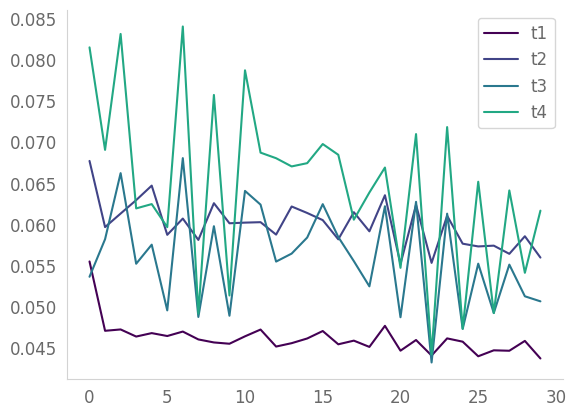

In [20]:
plt.plot(l_loss['0.0:1.0'],label = 't1')
plt.plot(l_loss['1.0:2.0'],label = 't2')
plt.plot(l_loss['2.0:3.0'],label = 't3')
plt.plot(l_loss['3.0:4.0'],label = 't4')
plt.legend()

### Test

In [21]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.02
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.0984419584274292,relative_mass_now:1.105
RME:0.005934879251195279
Otloss:0.0459433
total loss:0.0459433
epoch_0_1:
relative_mass_pred:1.316100001335144,relative_mass_now:1.325
RME:0.006716980124419557
Otloss:0.0568233
total loss:0.0568233
epoch_0_2:
relative_mass_pred:1.710716962814331,relative_mass_now:1.725
RME:0.008280021556909585
Otloss:0.0444161
total loss:0.0444161
epoch_0_3:
relative_mass_pred:2.3892316818237305,relative_mass_now:2.4225
RME:0.013733051878748981
Otloss:0.0462593
total loss:0.0462593


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

New minimum otloss found: 0.0462593212723732. Model saved.


In [28]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=100, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


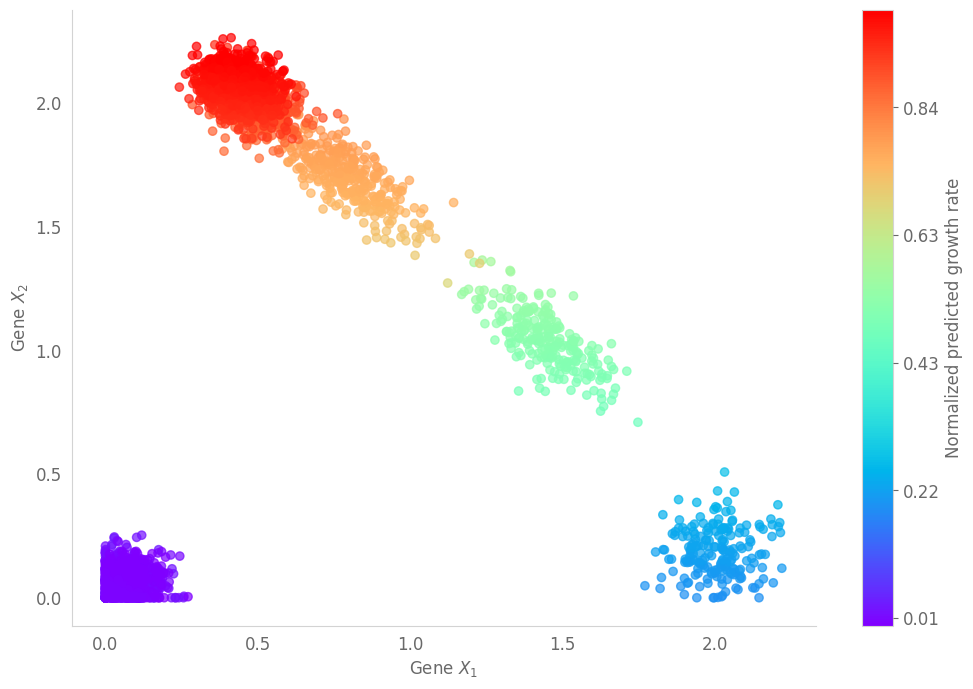

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        x = torch.tensor(subset['x1'].values, dtype=torch.float32).to(device)
        y = torch.tensor(subset['x2'].values, dtype=torch.float32).to(device)
        data = torch.stack([x, y], dim=1)
        
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 99)
    
    norm = plt.Normalize(vmin=all_g_values.min(), vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

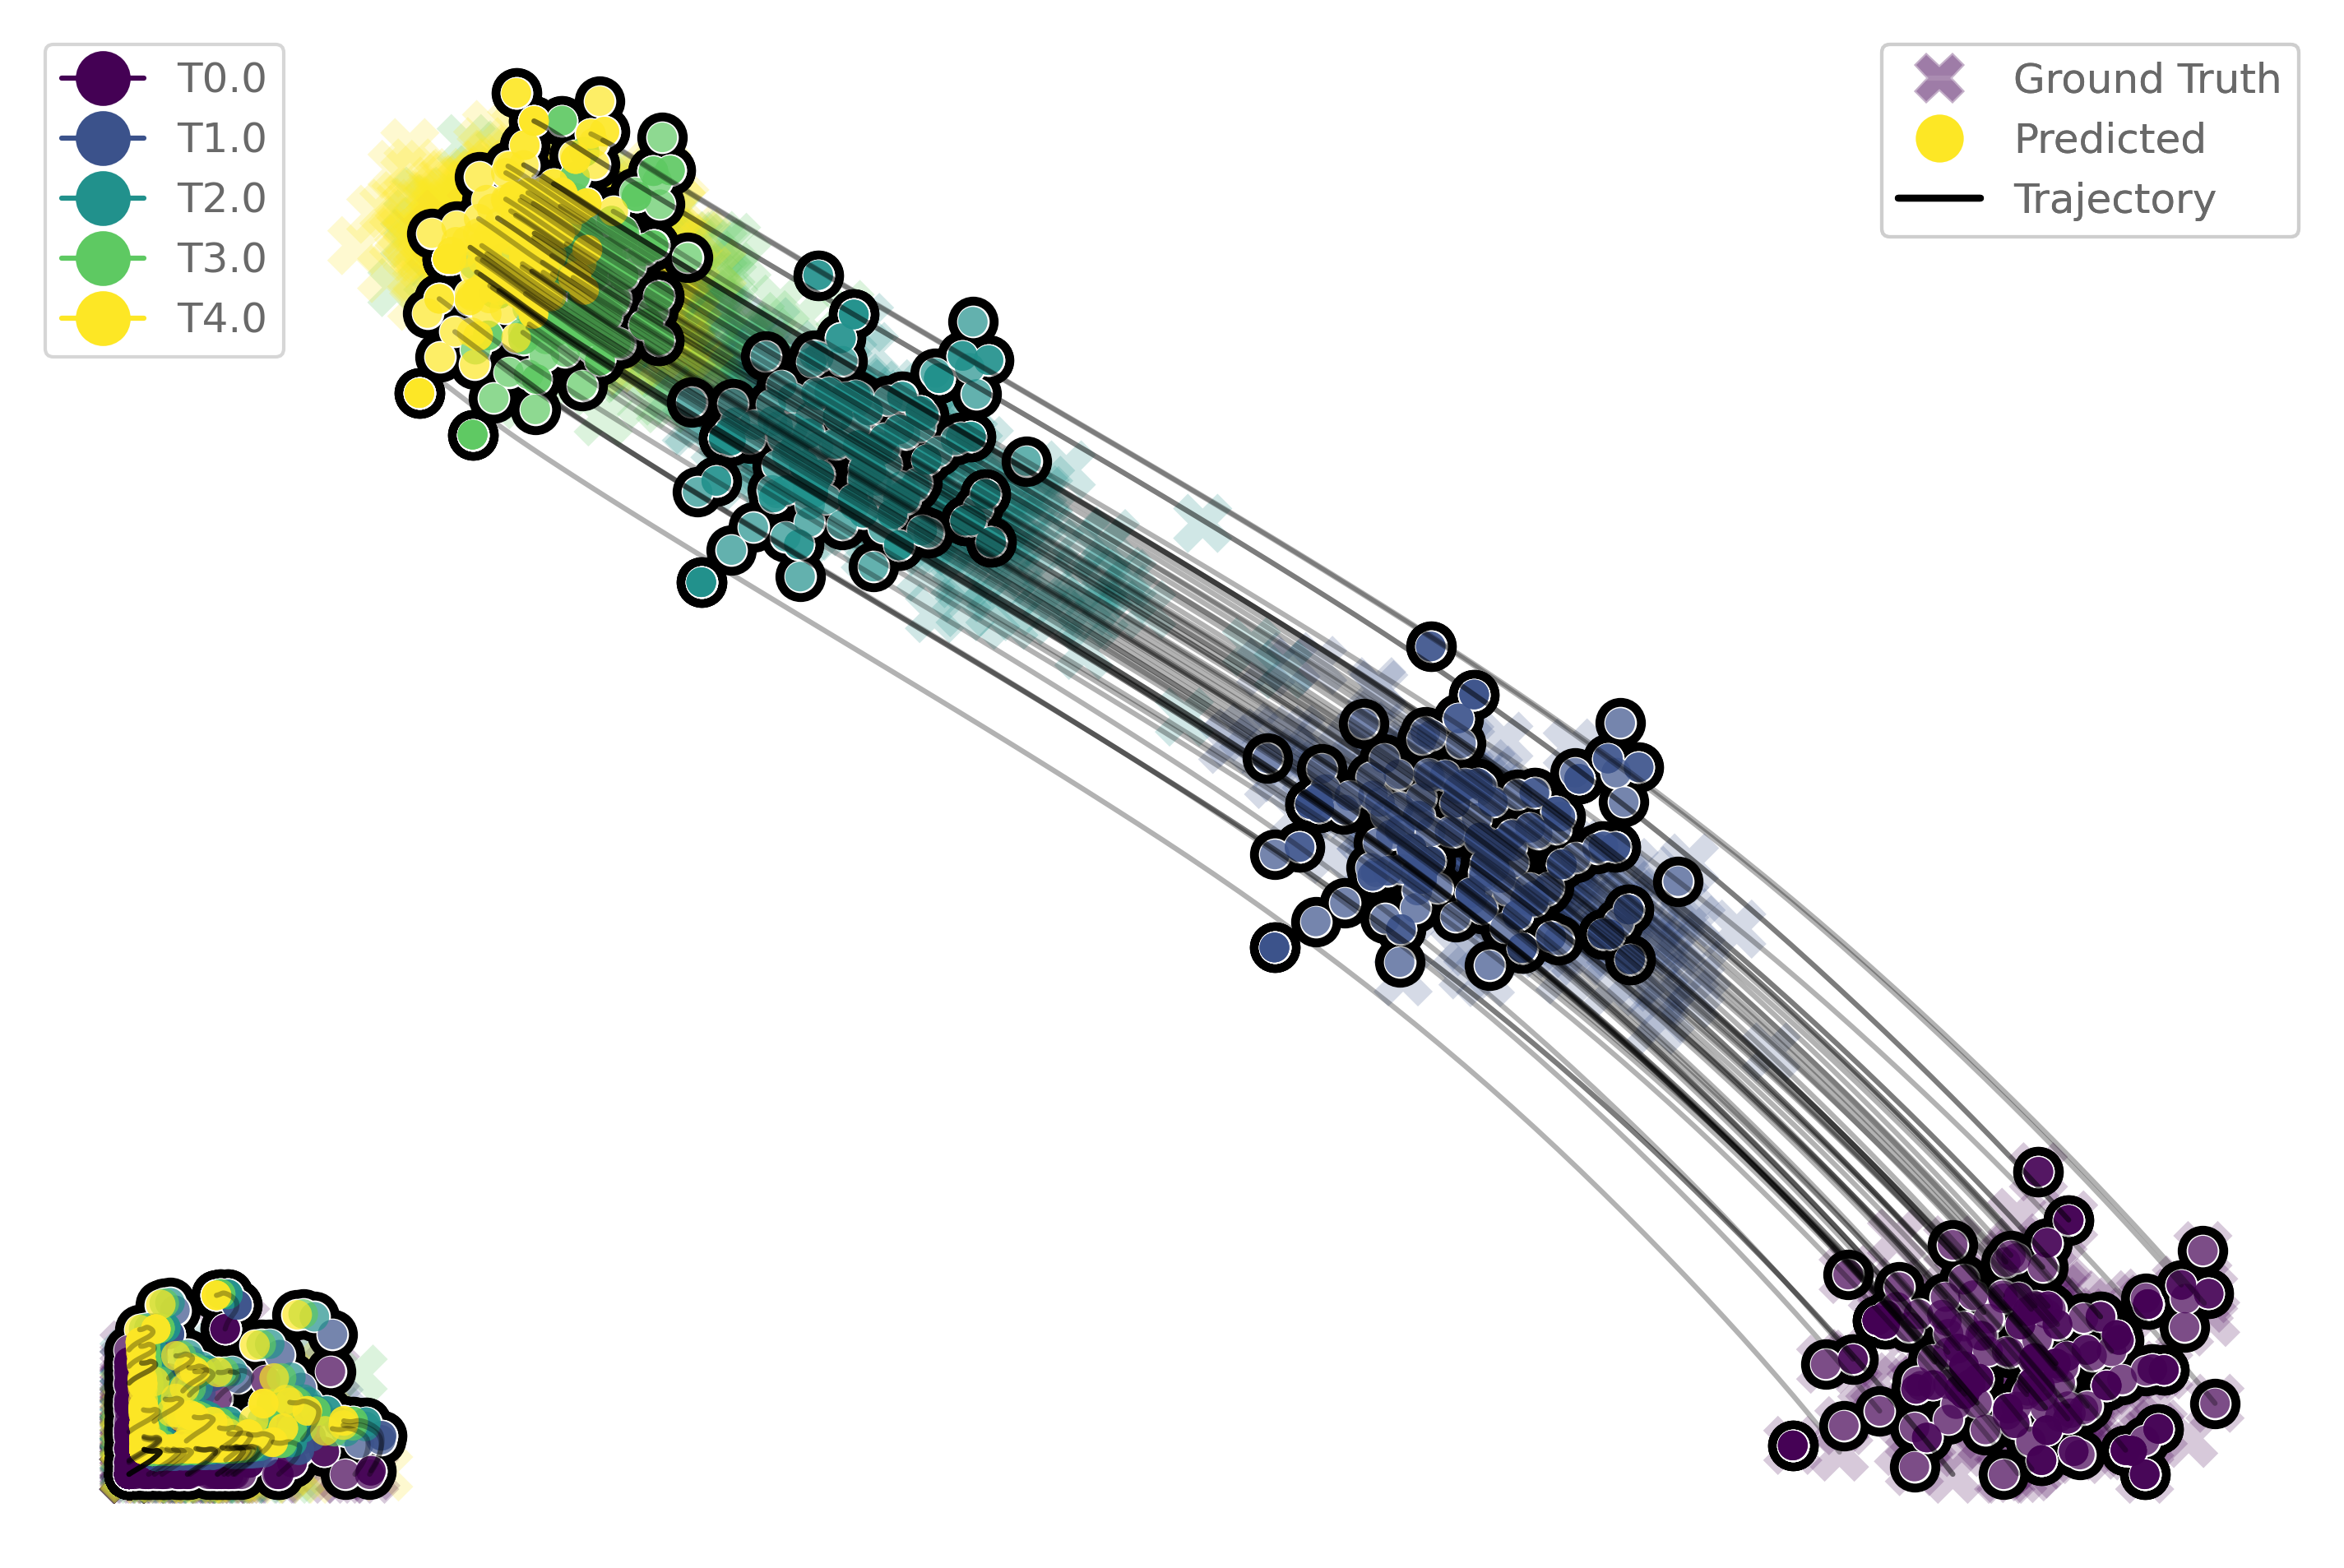

In [29]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)